In [2]:
import os
import s3fs
import torch

In [4]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET_X_TRUE_TRAIN = "antoinedp/x_true_train"
BUCKET_X_TRUE_TEST = "antoinedp/x_true_test"
BUCKET_X_FBP_TRAIN = "antoinedp/x_fbp_train"
BUCKET_X_FBP_TEST = "antoinedp/x_fbp_test"

x_true_train_filenames = fs.ls(BUCKET_X_TRUE_TRAIN)[1:]
x_true_test_filenames = fs.ls(BUCKET_X_TRUE_TEST)[1:]
x_fbp_train_filenames = fs.ls(BUCKET_X_FBP_TRAIN)[1:]
x_fbp_test_filenames = fs.ls(BUCKET_X_FBP_TEST)[1:]

In [5]:
import numpy as np

def import_data(file_paths):
    data = []
    for file_path in file_paths:
        with fs.open(file_path, mode="rb") as file_in:
            data.append(np.load(file_in, encoding="bytes"))
    return data
    
x_true_train = import_data(x_true_train_filenames)
x_true_test = import_data(x_true_test_filenames)
x_fbp_train = import_data(x_fbp_train_filenames)
x_fbp_test = import_data(x_fbp_test_filenames)

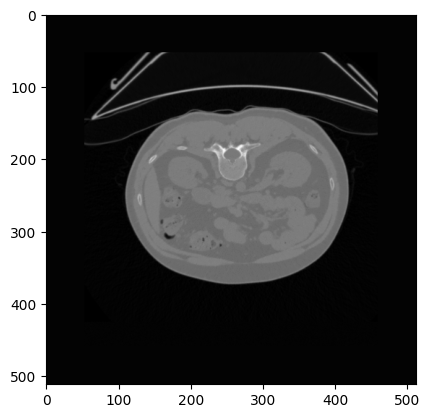

In [8]:
#!pip install matplotlib
from matplotlib import pyplot as plt
plt.imshow(x_true_train[1], cmap="gray")
plt.show()

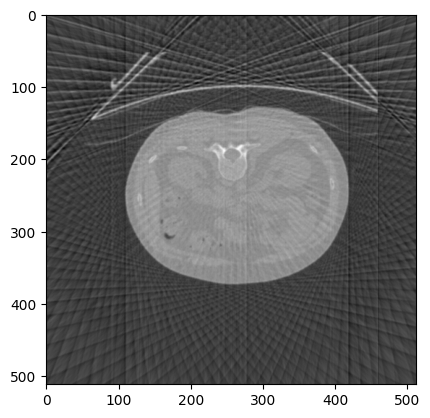

In [9]:
from matplotlib import pyplot as plt
plt.imshow(x_fbp_train[1], cmap="gray")
plt.show()

In [10]:
X_train, X_test, y_train, y_test = x_fbp_train, x_fbp_test, x_true_train, x_true_test

In [11]:
import numpy as np

# Stack the images along a new axis to calculate mean and std
stacked_x_train = np.stack(X_train, axis=0)
stacked_y_train = np.stack(y_train, axis=0)

# Calculate mean and std across all images
mean_x_train = np.mean(stacked_x_train)
std_x_train = np.std(stacked_x_train)
mean_y_train = np.mean(stacked_y_train)
std_y_train = np.std(stacked_y_train)

In [12]:
print(mean_x_train)
print(std_x_train)
print(mean_y_train)
print(std_y_train)

0.004652768
0.007871411
0.004438656
0.0076331864


In [13]:
import torch

X_train_tensor = torch.from_numpy(np.array(X_train)).to(dtype=torch.float32)
X_test_tensor = torch.from_numpy(np.array(X_test)).to(dtype=torch.float32)
y_train_tensor = torch.from_numpy(np.array(y_train)).to(dtype=torch.float32)
y_test_tensor = torch.from_numpy(np.array(y_test)).to(dtype=torch.float32)

X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
y_train_tensor = y_train_tensor.unsqueeze(1)
y_test_tensor = y_test_tensor.unsqueeze(1)

In [14]:
import torch
from torchvision import transforms

class DualHorizontalVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        input_image, output_image = sample['x'], sample['y']
        
        if torch.rand(1) < self.p:
            input_image = transforms.functional.hflip(input_image)
            output_image = transforms.functional.hflip(output_image)
        
        if torch.rand(1) < self.p:
            input_image = transforms.functional.vflip(input_image)
            output_image = transforms.functional.vflip(output_image)

        rotate_rand = torch.rand(1)

        if rotate_rand < self.p / 2:
            input_image = transforms.functional.rotate(input_image, angle = 90)
            output_image = transforms.functional.rotate(output_image, angle = 90)
        elif self.p / 2 <= rotate_rand < self.p:
            input_image = transforms.functional.rotate(input_image, angle = 180)
            output_image = transforms.functional.rotate(output_image, angle = 180)
        elif self.p <= rotate_rand < (1/2)*(1 + self.p):
            input_image = transforms.functional.rotate(input_image, angle = 270)
            output_image = transforms.functional.rotate(output_image, angle = 270) 
        else:
            pass
        
        return {'x': input_image, 'y': output_image}


In [15]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Define the transformation for flip-flop augmentation
flip_flop_transform = transforms.Compose([
    DualHorizontalVerticalFlip(p=0.5)
])

normalize_x = transforms.Compose([
    transforms.Normalize(mean=[mean_x_train], std=[std_x_train])
])

normalize_y = transforms.Compose([
    transforms.Normalize(mean=[mean_y_train], std=[std_y_train])
])

class CustomDataset(Dataset):
    
    def __init__(self, X, y, transform, target_transform, flip_flop_transform = None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.flip_flop_transform = flip_flop_transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        x = self.transform(self.X[idx])
        y = self.target_transform(self.y[idx])

        if self.flip_flop_transform:
            sample = {'x': x, 'y': y}
            flip_flop_transform = self.flip_flop_transform(sample)
            x = flip_flop_transform['x']
            y = flip_flop_transform['y']
                    
        return x, y

dataloader_train = DataLoader(CustomDataset(X_train_tensor, y_train_tensor, normalize_x, normalize_y, flip_flop_transform), batch_size=1, shuffle=True)
dataloader_test = DataLoader(CustomDataset(X_test_tensor, y_test_tensor, normalize_x, normalize_y), batch_size=1, shuffle=True)

In [16]:
img_x, img_y = next(iter(dataloader_train))
img_x_, img_y_ = img_x[0].squeeze(0).squeeze(0).numpy(), img_y[0].squeeze(0).squeeze(0).numpy()

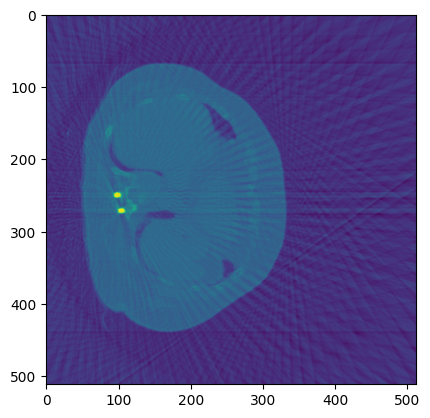

In [17]:
plt.imshow(img_x_)
plt.show()

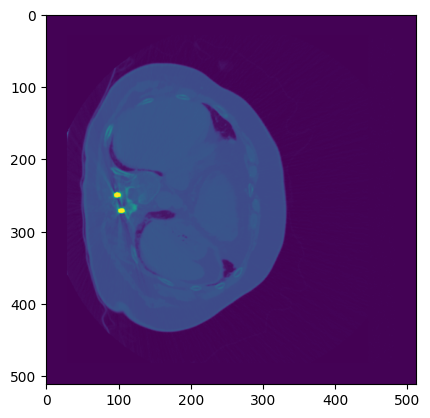

In [18]:
plt.imshow(img_y_)
plt.show()

In [19]:
import torch.nn as nn

class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.mp = nn.MaxPool2d(2, stride=2)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x, downsample=True):

        if downsample:
          x = self.mp(x)

        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))

        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn0 = nn.BatchNorm2d(in_channels//2)
        self.relu0 = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels//2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels//2, in_channels//2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels//2)
        self.relu2 = nn.ReLU()

    def forward(self, x1, x2):

        x1 = self.relu0(self.bn0(self.upconv(x1)))

        x = torch.cat([x2, x1], dim=1)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))

        return x


class UNet(nn.Module):
  def __init__(self, num_channels=1):
        super().__init__()

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.ds1 = DownSamplingBlock(64, 64)
        self.ds2 = DownSamplingBlock(64, 128)
        self.ds3 = DownSamplingBlock(128, 256)
        self.ds4 = DownSamplingBlock(256, 512)
        self.ds5 = DownSamplingBlock(512, 1024)

        self.us1 = UpSamplingBlock(1024)
        self.us2 = UpSamplingBlock(512)
        self.us3 = UpSamplingBlock(256)
        self.us4 = UpSamplingBlock(128)

        self.conv2 = nn.Conv2d(64, 1, 1)



  def forward(self, x):

      x0 = x
      x1 = self.relu1(self.bn1(self.conv1(x0)))
      
      x2 = self.ds1(x1, False)
      x3 = self.ds2(x2)
      x4 = self.ds3(x3)
      x5 = self.ds4(x4)
      x6 = self.ds5(x5)

      x7 = self.us1(x6, x5)
      x8 = self.us2(x7, x4)
      x9 = self.us3(x8, x3)
      x10 = self.us4(x9, x2)

      x11 = self.conv2(x10)
      x = x0 + x11
      return x
      

In [42]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad.clip_grad_value_(model.parameters(), clip_value=1e-2)
        optimizer.step()
        optimizer.zero_grad()

        # Display loss from time to time
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss: >7f}  [{current: >5d} / {size: >5d}]")
    
    scheduler.step()
    



def test_loop(dataloader, model, loss_fn, device, set = "Test"):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"\n{set} set: Avg loss: {test_loss: >8f} \n")
    return test_loss


def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, epochs, device, start_epoch = 0):
    for t in range(start_epoch, epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
        
        torch.save({'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss_fn}, 
        	'./modelL1.pth')
        
        test_loop(train_dataloader, model, loss_fn, device, set = "Training")
        test_loop(test_dataloader, model, loss_fn, device)

In [22]:
#load model 
from torch.optim import lr_scheduler, SGD
import math


def lr_lambda(epoch):
    return math.exp(-0.1*epoch)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
modelUnet = UNet().to(device)
optimizer = SGD(modelUnet.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


checkpoint = torch.load('./modelL1.pth')
modelUnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']

train(model=modelUnet,
      train_dataloader=dataloader_train,
      test_dataloader=dataloader_test,
      loss_fn=loss,
      optimizer=optimizer,
      scheduler=scheduler,
      epochs=epochs,
      device=device,
      start_epoch=start_epoch)



Epoch 99
-------------------------------
loss: 0.001450  [    1 /  2000]
loss: 0.003092  [  101 /  2000]
loss: 0.001272  [  201 /  2000]
loss: 0.001881  [  301 /  2000]


KeyboardInterrupt: 

In [31]:
img_x, img_y = next(iter(dataloader_test))

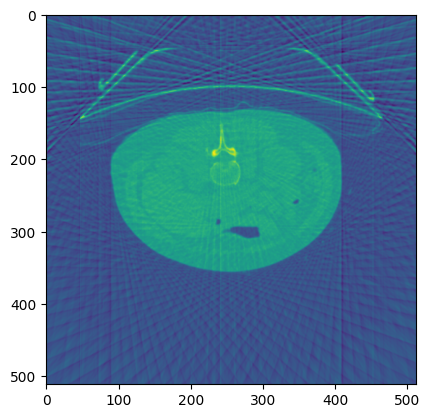

In [32]:
img_x_, img_y_ = img_x[0].squeeze(0).squeeze(0).numpy(), img_y[0].squeeze(0).squeeze(0).numpy()
plt.imshow(img_x_)
plt.show()

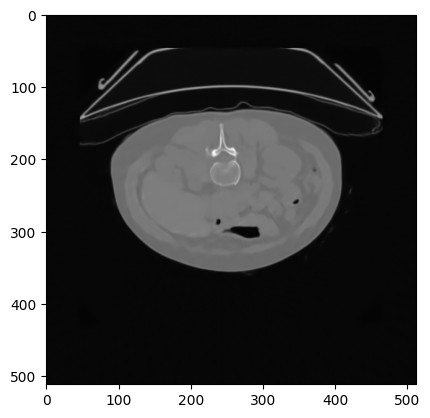

In [33]:
z = modelUnet(img_x.to(device))
plt.imshow(z.squeeze(0).squeeze(0).to('cpu').detach().numpy(), cmap="gray")
plt.show()

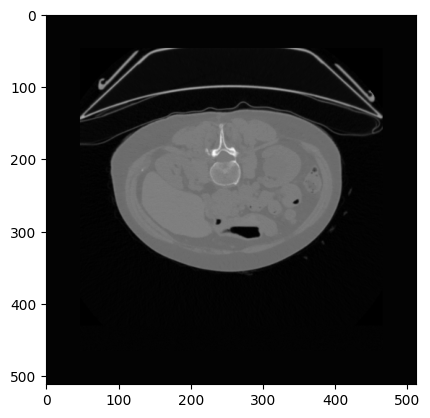

In [34]:
plt.imshow(img_y_, cmap="gray")
plt.show()